## Classification of Fruits by Transfer Learning

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
import keras

Using TensorFlow backend.


In [31]:
#importing the keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout
from keras.applications import VGG16

### Loading the VGG16 trained on 'imagenet' dataset

In [3]:
conv_base_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))

### Let's take a look at the archietecture of the model

In [4]:
conv_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

### Extracting features using pretrained convolutional network

In [6]:
import os
from keras.preprocessing.image import ImageDataGenerator

root_path = r'C:\Users\Dell\Desktop\Put in Github_all_our_tries\4. Deep Learning Datasets\Transfer learning_Classification of Fruits_360\fruits-360'
training_path = os.path.join(root_path, "Training")
testing_path = os.path.join(root_path, 'Test')
from PIL import Image
from keras import optimizers

In [7]:
os.path.exists(root_path)

True

In [8]:
os.path.exists(training_path)

True

In [9]:
os.path.exists(testing_path)

True

In [10]:
#Here we are just rescaling using Data Generator and didn't use any augmentation
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1
n_classes = 81

In [11]:
#extracting features from the conv nets

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3,3,512)) 
    labels = np.zeros(shape=(sample_count, n_classes))
    generator = datagen.flow_from_directory(directory, target_size=(100,100), 
                                            batch_size=batch_size, class_mode='categorical')
    
    i = 0
    
    for inputs_batch, label_batch in generator:
        features_batch = conv_base_vgg16.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = label_batch
        i = i+1
        if i*batch_size >= sample_count:
            break
    return features, labels

We are giving here that the features of dimension learned from the image is (sample_count, 3,3,512) because our model has final output of (None,None, None, 512) in model.summary(). Here sample_count may varies according to the training and testing and in the (3,3, 512) that (3,3) depends upon the model output

Here we are giving break since the generator in python yield data infinitely in a loop, so we have to break every image has been seen once

In [13]:
training_features , training_labels = extract_features(training_path, 41322)

Found 41322 images belonging to 81 classes.


In [14]:
testing_features, testing_labels = extract_features(testing_path, 13387)

Found 13877 images belonging to 81 classes.


In [15]:
training_features.shape

(41322, 3, 3, 512)

In [16]:
testing_features.shape

(13387, 3, 3, 512)

We can see that the training feature of shape (sample, 3,3,512) and we need to flatten them as (sample, 4608) before sending it to a dense fully connected layer.

In [25]:
training_features = np.reshape(training_features, newshape=(41322, 3*3*512))

In [27]:
training_features.shape

(41322, 4608)

We can see that the training features changed its shape as (sample, 4608)

In [29]:
testing_features = np.reshape(testing_features, newshape=(13387, (3*3*512)))

In [30]:
testing_features.shape

(13387, 4608)

## Defining and training the densely connected layer

In [33]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=(3*3*512)))
model.add(Dropout(0.5))
model.add(Dense(81, activation='softmax'))
model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', 
              metrics = ['acc'])
history = model.fit(training_features, training_labels, epochs=5, batch_size=100,
         validation_data = (testing_features, testing_labels))

Train on 41322 samples, validate on 13387 samples
Epoch 1/5
41322/41322 [==============================] - 15s 370us/step - loss: 0.0616 - acc: 0.9877 - val_loss: 0.0547 - val_acc: 0.9878
Epoch 2/5
41322/41322 [==============================] - 15s 359us/step - loss: 0.0501 - acc: 0.9882 - val_loss: 0.0445 - val_acc: 0.9888
Epoch 3/5
41322/41322 [==============================] - 15s 360us/step - loss: 0.0412 - acc: 0.9892 - val_loss: 0.0366 - val_acc: 0.9898
Epoch 4/5
41322/41322 [==============================] - 15s 375us/step - loss: 0.0341 - acc: 0.9903 - val_loss: 0.0303 - val_acc: 0.9904
Epoch 5/5
41322/41322 [==============================] - 16s 383us/step - loss: 0.0286 - acc: 0.9913 - val_loss: 0.0253 - val_acc: 0.9914


In just 5 epoch we can see that the training and testing accuracy reaches around 99%

### Visualizing the curves

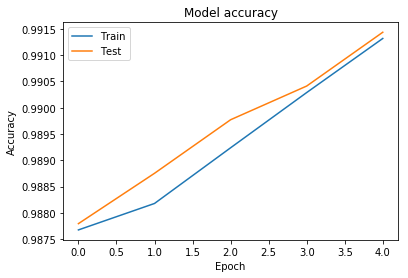

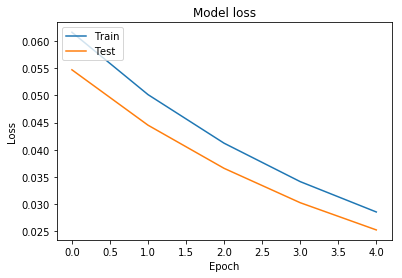

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The graph also shows the same as the training and validation accuracy both are at around 99%. Since data is large enough there is no need of augmentation here as it gives good accuracy using VGG16

## That's the end of the code